## Importing libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset3, AugTextDataset
from bert import CustomBert3, CustomBert5, CustomBert3b
from multilabel_cross_fold import MultilabelStratifiedKFold
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, FocalLoss
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

ModuleNotFoundError: No module named 'transformers'

## Loading and preparing data

In [7]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

FileNotFoundError: [Errno 2] File b'data/sample_submission.csv' does not exist: b'data/sample_submission.csv'

In [3]:
train['question'] = train['question_title'] + ' [SEP] ' + train['question_body']
test['question'] = test['question_title'] + ' [SEP] ' + test['question_body']
train['answer'] = train['question_title'] + ' [SEP] ' + train['answer']
test['answer'] = test['question_title'] + ' [SEP] ' + test['answer']

In [4]:
# %%time
# init_seed()
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# ids_train = {}
# ids_test = {}
# num_aug = 4
# max_seq_len = 512
# for mode, df in [('train', train), ('test', test)]:
#     for text in INPUTS:
#         ids = {i: [] for i in range(num_aug+1)}
#         for x in tqdm(df[text].values):
#             if len(x.split(' ')) > 10:
#                 augs = eda(x, alpha_sr=0.05, alpha_ri=0.05, alpha_rs=0.05, p_rd=0.05, num_aug=num_aug)[:-1]
#                 augs = [x] + augs
#             else:
#                 augs = (num_aug + 1) * [x]
#             encoded_inputs = []
#             for i, aug in enumerate(augs):
#                 encoded_inputs = tokenizer.encode_plus(
#                     aug, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True)['input_ids']
#                 ids[i] += [encoded_inputs]
#         if mode == 'train': ids_train[text] = [np.array(aug_ids) for aug_ids in ids.values()]
#         else: ids_test[text]  = [np.array(aug_ids) for aug_ids in ids.values()]

# for mode, ids in [('train', ids_train), ('test', ids_test)]:
#     question_ids = {i: [] for i in range(num_aug+1)}
#     for i in tqdm(range(len(ids['question_title'][0]))):
#         for j, aug in enumerate(augs):
#             qt_ids = ids['question_title'][j][i]
#             qb_ids = ids['question_body'][j][i]
#             q_ids = np.concatenate((qt_ids[qt_ids!=0], qb_ids[1:]))[:max_seq_len]
#             question_ids[j].append(q_ids)
#     if mode == 'train': ids_train['question'] = [np.array(aug_ids) for aug_ids in question_ids.values()]
#     else: ids_test['question']  = [np.array(aug_ids) for aug_ids in question_ids.values()]

In [5]:
%%time
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
ids_train = {}
ids_test = {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text in ['question', 'answer']:
        ids = []
        for x in tqdm(df[text].values):
            encoded_inputs = tokenizer.encode_plus(
                x, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True)
            ids.append(encoded_inputs['input_ids'])
        if mode == 'train': ids_train[text] = np.array(ids)
        else: ids_test[text] = np.array(ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 32.2 s, sys: 235 ms, total: 32.4 s
Wall time: 32.5 s


In [6]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [7]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)

In [9]:
num_workers = 10
bs = 2
TextDataset = TextDataset3

In [10]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [11]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_bert'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10
p_aug = 0.0

In [12]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 100, weight_decay)
#         + get_optimizer_param_groups(model.q_bert, lr / 100, weight_decay)
#         + get_optimizer_param_groups(model.a_bert, lr / 100, weight_decay)
    )

Fold 1 started at Thu Jan  9 07:37:49 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


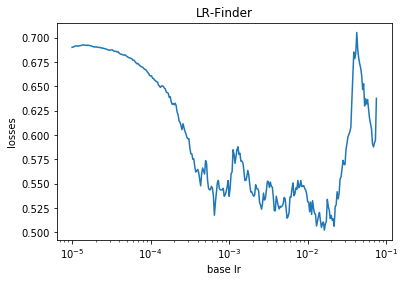

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50965 - spearmanr 0.24269
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47337 - spearmanr 0.38359


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.38359
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45732 - spearmanr 0.39207
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45765 - spearmanr 0.40723
best model: epoch 1 - 0.40723
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43305 - spearmanr 0.45879
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45341 - spearmanr 0.41294
best model: epoch 2 - 0.41294
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41117 - spearmanr 0.51393
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45681 - spearmanr 0.41435
best model: epoch 3 - 0.41435
TRAINING END: Best score achieved on epoch 3 - 0.41435
Starting inference for model: checkpoints/siamese_bert_fold_1_best.pth



Starting inference for model: checkpoints/siamese_bert_fold_1_best.pth



Fold 2 started at Thu Jan  9 08:17:42 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50781 - spearmanr 0.24455
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47338 - spearmanr 0.3886
best model: epoch 0 - 0.3886
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45719 - spearmanr 0.39198
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45814 - spearmanr 0.40956
best model: epoch 1 - 0.40956
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43231 - spearmanr 0.4593
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45689 - spearmanr 0.41704
best model: epoch 2 - 0.41704
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.4098 - spearmanr 0.51455
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46077 - spearmanr 0.41313
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41704
Starting inference for model: checkpoints/siamese_bert_fold_2_best.pth



Starting inference for model: checkpoints/siamese_bert_fold_2_best.pth



Fold 3 started at Thu Jan  9 08:56:10 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50902 - spearmanr 0.2459
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.4749 - spearmanr 0.37151
best model: epoch 0 - 0.37151
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.4568 - spearmanr 0.39309
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45898 - spearmanr 0.3996
best model: epoch 1 - 0.3996
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43277 - spearmanr 0.45788
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45916 - spearmanr 0.40092
best model: epoch 2 - 0.40092
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41018 - spearmanr 0.5154
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46323 - spearmanr 0.39683
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40092
Starting inference for model: checkpoints/siamese_bert_fold_3_best.pth



Starting inference for model: checkpoints/siamese_bert_fold_3_best.pth



Fold 4 started at Thu Jan  9 09:34:38 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50761 - spearmanr 0.24918
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47331 - spearmanr 0.35844
best model: epoch 0 - 0.35844
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45704 - spearmanr 0.39496
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45802 - spearmanr 0.38823
best model: epoch 1 - 0.38823
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43237 - spearmanr 0.46107
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45712 - spearmanr 0.39684
best model: epoch 2 - 0.39684
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40985 - spearmanr 0.51598
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46074 - spearmanr 0.39498
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39684
Starting inference for model: checkpoints/siamese_bert_fold_4_best.pth



Starting inference for model: checkpoints/siamese_bert_fold_4_best.pth



Fold 5 started at Thu Jan  9 10:13:07 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50843 - spearmanr 0.24912
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46894 - spearmanr 0.37509
best model: epoch 0 - 0.37509
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45697 - spearmanr 0.39592
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45311 - spearmanr 0.39605
best model: epoch 1 - 0.39605
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43219 - spearmanr 0.4619
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45341 - spearmanr 0.40346
best model: epoch 2 - 0.40346
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40994 - spearmanr 0.51758
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45487 - spearmanr 0.40196
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40346
Starting inference for model: checkpoints/siamese_bert_fold_5_best.pth



Starting inference for model: checkpoints/siamese_bert_fold_5_best.pth



Fold 6 started at Thu Jan  9 10:51:36 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50965 - spearmanr 0.24727
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46552 - spearmanr 0.36537
best model: epoch 0 - 0.36537
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45655 - spearmanr 0.39647
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45748 - spearmanr 0.38276
best model: epoch 1 - 0.38276
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43263 - spearmanr 0.46107
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45123 - spearmanr 0.3923
best model: epoch 2 - 0.3923
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41076 - spearmanr 0.51502
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45559 - spearmanr 0.39024
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39230
Starting inference for model: checkpoints/siamese_bert_fold_6_best.pth



Starting inference for model: checkpoints/siamese_bert_fold_6_best.pth



Fold 7 started at Thu Jan  9 11:30:04 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50832 - spearmanr 0.24769
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47277 - spearmanr 0.36978
best model: epoch 0 - 0.36978
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45631 - spearmanr 0.39507
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46212 - spearmanr 0.40282
best model: epoch 1 - 0.40282
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43203 - spearmanr 0.46055
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45917 - spearmanr 0.40824
best model: epoch 2 - 0.40824
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40973 - spearmanr 0.51461
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46267 - spearmanr 0.41022
best model: epoch 3 - 0.41022
TRAINING END: Best score achieved on epoch 3 - 0.41022
Starting inference for model: checkpoints/siamese_bert_fold_7_best.pth



Starting inference for model: checkpoints/siamese_bert_fold_7_best.pth



Fold 8 started at Thu Jan  9 12:08:34 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50909 - spearmanr 0.24253
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.4727 - spearmanr 0.38614
best model: epoch 0 - 0.38614
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45611 - spearmanr 0.39322
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46698 - spearmanr 0.40324
best model: epoch 1 - 0.40324
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43203 - spearmanr 0.45899
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.46381 - spearmanr 0.41322
best model: epoch 2 - 0.41322
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40956 - spearmanr 0.51543
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46969 - spearmanr 0.41081
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41322
Starting inference for model: checkpoints/siamese_bert_fold_8_best.pth



Starting inference for model: checkpoints/siamese_bert_fold_8_best.pth



Fold 9 started at Thu Jan  9 12:47:03 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50903 - spearmanr 0.2455
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47246 - spearmanr 0.36838
best model: epoch 0 - 0.36838
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45685 - spearmanr 0.39534
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45759 - spearmanr 0.3928
best model: epoch 1 - 0.3928
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43215 - spearmanr 0.46187
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45844 - spearmanr 0.40157
best model: epoch 2 - 0.40157
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40983 - spearmanr 0.51598
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.4605 - spearmanr 0.40316
best model: epoch 3 - 0.40316
TRAINING END: Best score achieved on epoch 3 - 0.40316
Starting inference for model: checkpoints/siamese_bert_fold_9_best.pth



Starting inference for model: checkpoints/siamese_bert_fold_9_best.pth



Fold 10 started at Thu Jan  9 13:25:33 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50976 - spearmanr 0.24387
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46102 - spearmanr 0.38478
best model: epoch 0 - 0.38478
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45832 - spearmanr 0.39205
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45045 - spearmanr 0.40994
best model: epoch 1 - 0.40994
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43314 - spearmanr 0.45979
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44905 - spearmanr 0.4148
best model: epoch 2 - 0.4148
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41064 - spearmanr 0.51578
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45006 - spearmanr 0.41396
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41480
Starting inference for model: checkpoints/siamese_bert_fold_10_best.pth



Starting inference for model: checkpoints/siamese_bert_fold_10_best.pth



OOF score: 0.40585502844535415


In [13]:
init_seed()
# folds = MultilabelStratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42).split(
#     X=train['question_body'], y=y)
folds = GroupKFold(n_splits=n_folds).split(
    X=train['question_body'], groups=train['question_body'])#KFold(n_splits=5, random_state=42).split(train)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'], train_index, #p_aug=p_aug,
                       targets=y), batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'], valid_index, #p_aug=0.0, 
                       targets=y), batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#KFold 5: distilbert: 0.4160
#GKFold 5: distilbert: ~0.4005, ~0.4130, distilbert eda: ~0.4000, ~0.4200 (unsure), bert siamese: 0.4040, 0.4188
    # smoothing y dist -> ~0.005 CV improve
#GKFold 10: distilbert: 0.4012, ~0.4195, bert siamese(smoothing): 0.4059, 0.4206, 0.4275
#MLFold 5: bert siamese: 0.4118, 0.4355, 04373

In [28]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

def scale(x, d):
    if d: return (x//(1/d))/d
    else: return x

indices = [2, 5, 12, 13, 14, 15]
ds = [10, 5, 5, 20, 5, 5]
discrete_cols = np.array(TARGETS)[indices]
print(discrete_cols)

def ahmet_round(preds, ds=ds, indices=indices):
    new_preds = preds.copy()
    for idx, d in zip(indices, ds):
        new_preds[:,idx] = scale(preds[:,idx], d)
    return new_preds

['question_conversational' 'question_has_commonly_accepted_answer'
 'question_type_compare' 'question_type_consequence'
 'question_type_definition' 'question_type_entity']


In [65]:
from scipy.stats import spearmanr
opt_ds = []
opt_indices = []
for idx in range(N_TARGETS):
    opt_score = 0
    opt_d = None
    for d in [3, 5, 10, 15, 20, 33, None]:
        score = spearmanr(scale(oofs[:,idx], d), y[:,idx])[0]
        if score > opt_score:
            opt_score = score
            opt_d = d
            print(idx, d, score)
    if opt_d:
        opt_ds.append(opt_d)
        opt_indices.append(idx)

0 3 0.31166158837705044
0 5 0.35397568402275564
0 10 0.3764541313527571
0 15 0.3797484731999951
0 20 0.3829442576019711
0 33 0.3830204484565
0 None 0.3847138595082513
1 3 0.572046578040876
1 5 0.5958533831811501
1 10 0.6097331707721845
1 15 0.6103319281254339
1 20 0.6122982760804527
1 33 0.612545193099545
1 None 0.6128561334335777
2 3 0.4677231242187947
2 5 0.4714423042343309
2 10 0.47374837678956905
3 3 0.2599954037527897
3 5 0.2891608054180126
3 10 0.30384069726158186
3 20 0.30725818366879365
4 3 0.3203629362198194
4 5 0.3499379190699109
4 10 0.353813272261322
4 15 0.3539055036275413
4 None 0.3542753986536124
5 3 0.46105948573501654
6 3 0.24870998390193433
6 5 0.3247508255244423
6 10 0.35127621679822935
6 15 0.3549641071480202
6 20 0.357764481070059
7 3 0.4883587715629961
7 5 0.5023963455343653
7 10 0.5078498691610029
7 15 0.5101572594388418
8 3 0.5484184385271833
8 5 0.5712838687513432
8 10 0.5755432620372537
9 5 0.10794679875717782
9 20 0.10885865418063956
9 33 0.12485885134013819


In [66]:
opt_ds, opt_indices

([10, 20, 3, 20, 15, 10, 33, 5, 3, 10, 5, 5, 10, 20, 10, 20, 20, 33, 20, 33],
 [2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 23, 24, 25, 26, 28])

In [67]:
spearmanr_np(ahmet_round(oofs, opt_ds, opt_indices), y)

0.44493908540323845

In [86]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0
spearmanr_np(ahmet_round(oofs_alt, opt_ds, opt_indices), y)

0.44493908540323845

In [56]:
spearmanr_np(oofs, y)

0.40585502844535415

In [57]:
spearmanr_np(round_preds(oofs, high_num=3), y)

0.4204715255416341

In [58]:
spearmanr_np(ahmet_round(oofs), y)

0.42746722504683055

In [18]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [19]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.858062,0.646942,0.352087,0.386831,0.584030,0.389470,0.699762,0.706338,0.746779,0.005004,0.673240,0.741497,0.024043,0.524556,0.006623,0.021287,0.098566,0.182391,0.752002,0.000811,0.859794,0.516527,0.177644,0.679201,0.665737,0.281577,0.029315,0.037400,0.671770,0.567216
1,46,0.500766,0.337950,0.011108,0.688314,0.636571,0.855184,0.436080,0.389232,0.056869,0.010802,0.495959,0.300939,0.005182,0.000590,0.000680,0.014118,0.888499,0.321234,0.072577,0.000138,0.265544,0.762856,0.475982,0.860106,0.925981,0.578280,0.943354,0.205721,0.036234,0.578104
2,70,0.693205,0.523790,0.024682,0.680738,0.828795,0.931101,0.494496,0.376892,0.344702,0.001546,0.275064,0.866506,0.012330,0.030228,0.001028,0.002548,0.149194,0.122979,0.671731,0.000139,0.636495,0.705672,0.311053,0.854729,0.855073,0.493392,0.057845,0.066952,0.842082,0.556461
3,132,0.612409,0.219453,0.006763,0.624155,0.650047,0.855665,0.384227,0.253824,0.184865,0.008036,0.587494,0.186791,0.002403,0.003355,0.000455,0.003444,0.788334,0.297235,0.608626,0.000082,0.490324,0.782901,0.560746,0.865518,0.907732,0.617128,0.840626,0.316491,0.615011,0.651230
4,200,0.785256,0.336335,0.049969,0.805337,0.724569,0.879962,0.693937,0.729175,0.146082,0.033987,0.314221,0.512438,0.009688,0.025617,0.009406,0.063774,0.197841,0.215130,0.516147,0.003313,0.359070,0.767050,0.592056,0.877281,0.885139,0.685550,0.210222,0.232558,0.699671,0.597767


In [4]:
len(train)

NameError: name 'train' is not defined